Здесь будем фигачить признаки для деревьев, поэтому скоррелированные не выкидываем

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import pandas_profiling

In [40]:
sns.set_context('talk')

In [41]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [42]:
test = pd.read_csv('csv/ech_test.csv', sep=';', index_col='id')
train = pd.read_csv('csv/ech_apprentissage.csv', sep=';', index_col='id')

/home/alexey/anaconda3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Graphs

In [43]:
train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'puis_fiscale', 'anc_veh',
       'codepostal', 'energie_veh', 'kmage_annuel', 'crm', 'profession',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17',
       'var18', 'var19', 'var20', 'var21', 'var22', 'prime_tot_ttc'],
      dtype='object')

Заменим NR на NaN

In [44]:
train.replace('NR', np.NaN, inplace=True)
test.replace('NR', np.NaN, inplace=True)

Заменим ARMEE в codepostal на -1

In [45]:
train.loc[train.codepostal == 'ARMEE', 'codepostal'] = '-1'

In [46]:
train.loc[train.codepostal == '-1', 'codepostal']

id
46294    -1
46295    -1
46296    -1
Name: codepostal, dtype: object

Переведём codepostal в числа

In [47]:
train.codepostal = pd.to_numeric(train.codepostal)

In [48]:
test.codepostal.dtype

dtype('int64')

С тестом всё норм

Разделим codepostal на часть, относящуюся к региону, и на остальное. Учтём всякие крайние случаи типа заморских территорий.

In [49]:
def split_postcode(df):
    df['department'] = df['codepostal'] // 1000
    df['subreg'] = df['codepostal'] % 1000
    overseas = (df['department'] == 98) | (df['department'] == 97)
    df.ix[overseas, 'department'] = df['codepostal'] // 100
    df.ix[overseas, 'subreg'] = df['codepostal'] % 100
    return df.drop('codepostal', axis=1)

In [50]:
train = split_postcode(train)

In [51]:
test = split_postcode(test)

Посмотрим на категориальные

In [52]:
categorical = []
for col in train.columns:
    if train[col].dtype not in ['int64', 'float64']:
        print(col, train[col].dtype)
        categorical.append(col)

marque object
energie_veh object
profession object
var6 object
var7 object
var8 object
var14 object
var16 object


In [53]:
for col in categorical:
    print(col, '\n', set(train[col]), '\n\n')

marque 
 {nan, 'JIDE', 'BERTONE', 'STEYR PUCH', 'HOTCHKISS', 'WILLYS', 'BREMACH', 'OLDSMOBILE', 'LORENZ', 'AMC', 'CHENARD ET WALKER', 'PGO', 'EAGLE', 'MAHINDRA', 'SOVRA', 'OPEL', 'BEDFORD', 'PANTHER', 'HYUNDAI', 'MERCEDES', 'TALBOT', 'DONKERVOORT', 'INTERNATIONAL', 'PONTIAC', 'UNIMOG', 'MEGA', 'COURNIL', 'NISSAN', 'MOKE', 'CATERHAM', 'DAF', 'STRAUBENHARDT', 'WIESMANN', 'EBS', 'LAND-ROVER', 'PROTON', 'LOTUS', 'PORSCHE', 'AUSTIN', 'NSU', 'NECKAR', 'SMS', 'AUTO-UNION', 'SANTANA', 'SAVIEM', 'GME', 'TEILHOL', 'TOYOTA', 'DODGE', 'RELIANT', 'PLYMOUTH', 'SALMSON', 'TATA', 'ROLLS ROYCE', 'CHRYSLER', 'LDV', 'ENGIN TRAVAUX PUBLIC', 'MERCURY', 'VAUXHALL', 'BRM', 'MORGAN', 'MARUTI', 'VOLVO', 'EBRO', 'MCC', 'DAEWOO', 'MITSUBISHI', 'MASERATI', 'JEEP', 'ROVER', 'PEUGEOT', 'AUVERLAND', 'PININFARINA', 'ASTON MARTIN', 'SKODA', 'DAIHATSU', 'PANHARD', 'MINI', 'FIAT', 'FERRARI', 'DANGEL', 'LEXUS', 'PONCIN', 'GMC', 'HUMMER', 'ENGIN SPECIAL', 'LADA', 'SINGER', 'CARBODIES', 'AUTOLAND', 'IVECO', 'RAYTON FISSORE

Переведём в численные те признаки, которые посчитались за категориальные, потому что в них был NR (var7, var16). 

In [54]:
train.var7 = pd.to_numeric(train.var7)
train.var16 = pd.to_numeric(train.var16)

In [55]:
test.var7 = pd.to_numeric(test.var7)
test.var16 = pd.to_numeric(test.var16)

Опять посмотрим, но сразу с тестом

In [56]:
categorical = []
bigX = pd.concat([train.drop('prime_tot_ttc', axis=1), test])
for col in bigX.columns:
    if bigX[col].dtype not in ['int64', 'float64']:
        categorical.append(col)
for col in categorical:
    s = set(bigX[col])
    print(col, len(s), '\n', s, '\n\n')        

marque 157 
 {nan, 'JIDE', 'BERTONE', 'STEYR PUCH', 'HOTCHKISS', 'WILLYS', 'BREMACH', 'OLDSMOBILE', 'LORENZ', 'AMC', 'CHENARD ET WALKER', 'PGO', 'EAGLE', 'MAHINDRA', 'SOVRA', 'OPEL', 'BEDFORD', 'PANTHER', 'HYUNDAI', 'MERCEDES', 'TALBOT', 'DONKERVOORT', 'INTERNATIONAL', 'PONTIAC', 'UNIMOG', 'MEGA', 'COURNIL', 'NISSAN', 'MOKE', 'SOVAM', 'CATERHAM', 'DAF', 'STRAUBENHARDT', 'WIESMANN', 'EBS', 'LAND-ROVER', 'PROTON', 'LOTUS', 'PORSCHE', 'AUSTIN', 'NSU', 'NECKAR', 'SMS', 'AUTO-UNION', 'SANTANA', 'SAVIEM', 'GME', 'TEILHOL', 'TOYOTA', 'DODGE', 'RELIANT', 'PLYMOUTH', 'SALMSON', 'TATA', 'ROLLS ROYCE', 'CHRYSLER', 'LDV', 'ENGIN TRAVAUX PUBLIC', 'MERCURY', 'VAUXHALL', 'BRM', 'MORGAN', 'MARUTI', 'VOLVO', 'EBRO', 'MCC', 'DAEWOO', 'MITSUBISHI', 'MASERATI', 'JEEP', 'ROVER', 'PEUGEOT', 'AUVERLAND', 'PININFARINA', 'ASTON MARTIN', 'SKODA', 'DAIHATSU', 'PANHARD', 'MINI', 'FIAT', 'FERRARI', 'DANGEL', 'LEXUS', 'PONCIN', 'GMC', 'HUMMER', 'ENGIN SPECIAL', 'LADA', 'SINGER', 'CARBODIES', 'AUTOLAND', 'IVECO', 'R

В категорию маломощных категориалов выделяются var14, var6, energie_veh.

Средние var8, proffession

Большие marque

В категориях var6, var14 значение N похоже на пропуск. В тесте var14 только N

In [57]:
train.groupby('var14').size()

var14
A    62469
B    62449
C    34351
D    32757
E    11505
F    46276
G    45126
N     5067
dtype: int64

In [58]:
test.groupby('var14').size()

var14
N    30000
dtype: int64

Посморим на var6

In [59]:
train.groupby('var6').size()

var6
A     88583
B    115658
C     77203
D     17978
N       578
dtype: int64

In [60]:
test.groupby('var6').size()

var6
A    10110
B    12262
C     6610
D     1000
N       18
dtype: int64

var6 не сильно различается у трейна и теста

Посмотрим на распределения department в зависимости от var14

In [97]:
def plot_dists(grouped):
    row_count = grouped.ngroups
    fig, axs = plt.subplots(figsize=(18,40), 
                            nrows=row_count, ncols=1) 

    targets = zip(sorted(grouped.groups.keys()), axs.flatten())
    for i, (key, ax) in enumerate(targets):
        grouped.get_group(key).value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_title(key)
    plt.tight_layout()
    plt.show()

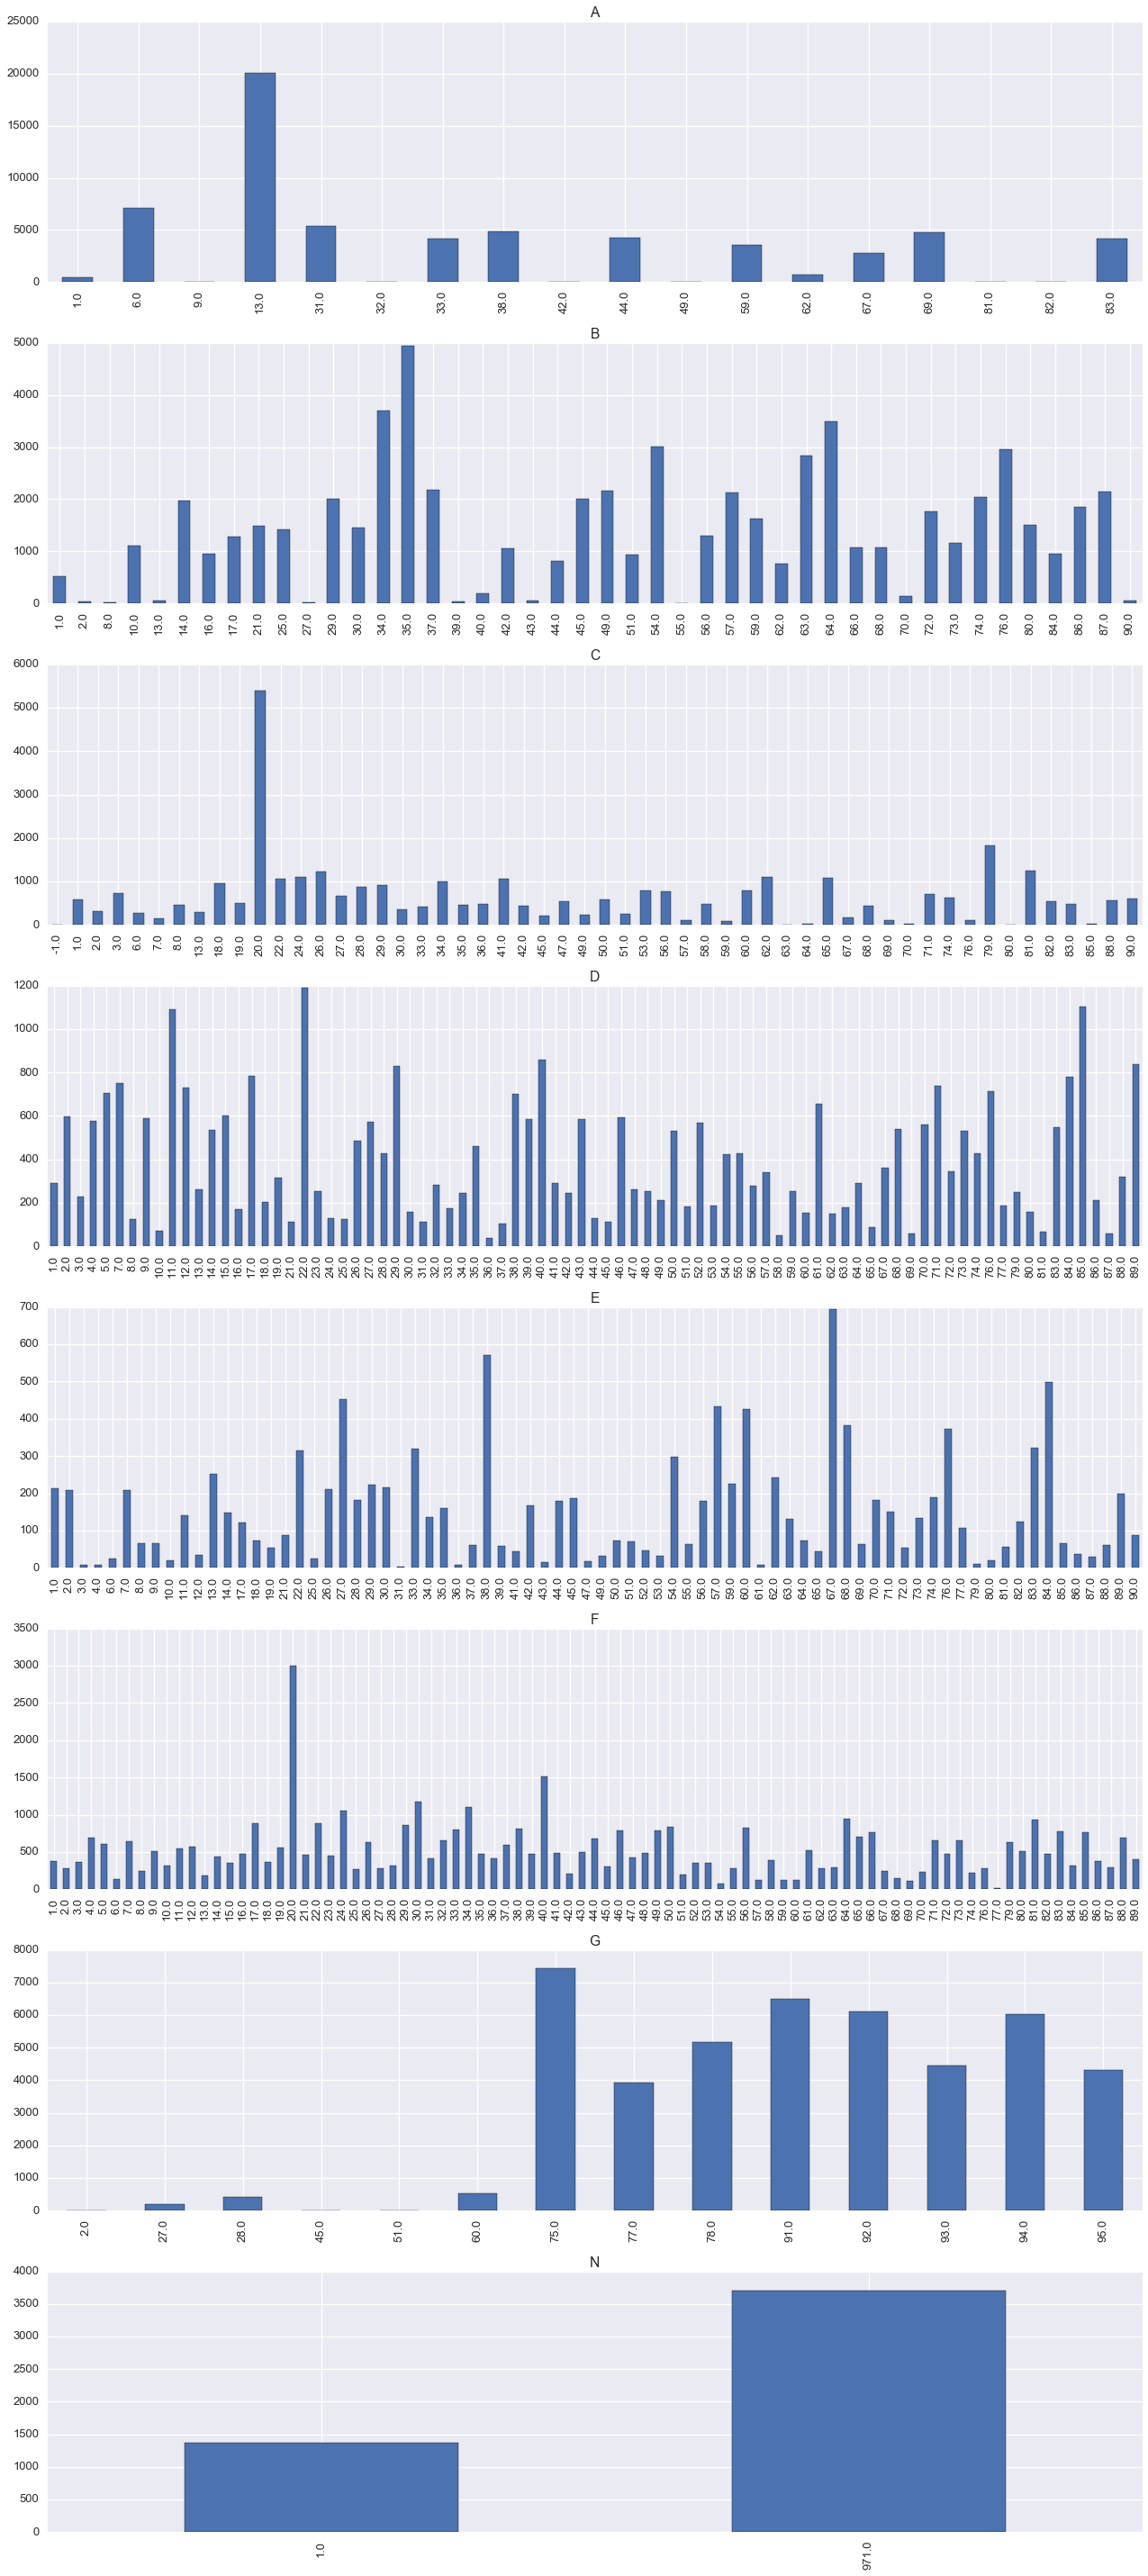

In [98]:
grouped = train.groupby('var14')['department']
plot_dists(grouped)

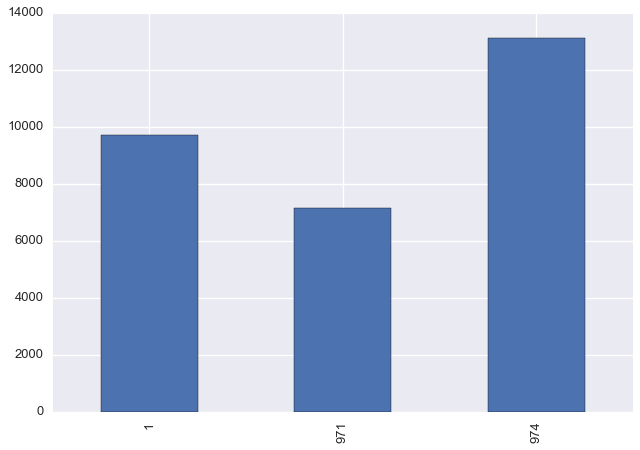

In [85]:
test['department'].value_counts().sort_index().plot(kind='bar')

У каждого департамента свой уникальный профиль в var14

In [155]:
department_profile = train.groupby(['department', 'var14']).size().unstack().fillna(0)

In [159]:
department_profile.tail(10)

var14,A,B,C,D,E,F,G,N
department,,,,,,,,
87.0,0.0,2155.0,0.0,58.0,30.0,291.0,0.0,0.0
88.0,0.0,0.0,566.0,322.0,62.0,687.0,0.0,0.0
89.0,0.0,0.0,0.0,839.0,200.0,396.0,0.0,0.0
90.0,0.0,64.0,611.0,0.0,88.0,0.0,0.0,0.0
91.0,0.0,0.0,0.0,0.0,0.0,0.0,6501.0,0.0
92.0,0.0,0.0,0.0,0.0,0.0,0.0,6099.0,0.0
93.0,0.0,0.0,0.0,0.0,0.0,0.0,4460.0,0.0
94.0,0.0,0.0,0.0,0.0,0.0,0.0,6021.0,0.0
95.0,0.0,0.0,0.0,0.0,0.0,0.0,4312.0,0.0


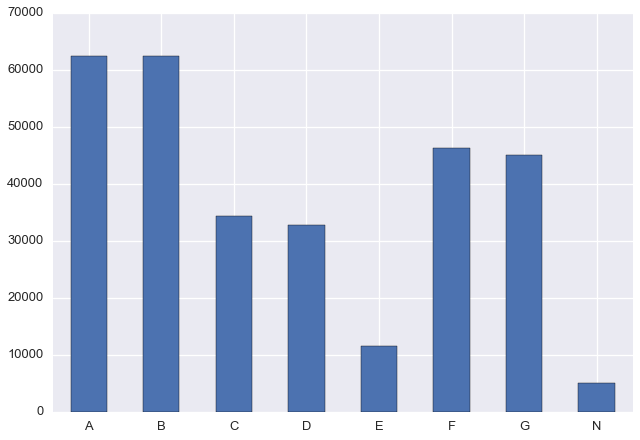

In [152]:
train['var14'].value_counts().sort_index().plot(kind='bar', rot=0)

Добавим признак "возраст получения прав"

Категориальные признаки с небольшой мощностью декодируем, с большой -- предпосчитаем средний таргет (медиану, моду). Агрегаты считаются по региону

В тесте есть регионы, не покрытые трейном

Тогда считаем агрегаты не по таргету, а по наиболее коррелированному с таргетом признаку. Ещё можно частоту вхождения включить

# Target label separation 

In [28]:
y_train = train['prime_tot_ttc']
train = train.drop('prime_tot_ttc', axis=1)

# Save to file

In [31]:
y_train.to_csv('preprocessed_csv/y_train_tree.csv', sep=';')

In [32]:
train.to_csv('preprocessed_csv/train_tree.csv', sep=';')

In [33]:
test.to_csv('preprocessed_csv/test_tree.csv', sep=';')